# A Project on Melanoma Identification
- By Ankitha Giridhar

# MELANOMA
Melanoma is a cancer that develops from melanocytes, which are pigment-producing cells on the skin. It is the deadliest type of skin cancer, accounting for three fourths of all skin cancer deaths, despite being the least common kind. 

At present, the diagnosis of Melanoma involves dermatologists manually inspecting mole on a patient's skin.
Melanoma is a deadly disease, but if caught early, most melanomas can be cured with minor surgery, which often proves to be inefficient. 

Though fatal if detected late, early-stage Melanoma can be eliminated via minor surgery. Hence, an AI approach using the images of the lesions is a bid towards improving the efficiency in Melanoma diagnosis, and potentially saving the lives of many patients

# Use Case
To classify a tumour as benign or malignant based on the images and metadata provided

# Imports

In [1]:
import numpy as np
import pandas as pd
import cv2
import PIL
from PIL import Image
import re
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
import glob
import tensorflow.keras.applications.densenet as dense
from kaggle_datasets import KaggleDatasets
import seaborn as sns
import plotly.express as px
from sklearn.metrics import roc_auc_score

In [2]:
tf.__version__

'2.2.0'

In [3]:
train = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

print('Train: ', train.shape)
print("Test:", test.shape)

Train:  (33126, 8)
Test: (10982, 5)


# Exploratory Data Analysis and Preprocessing
The data provided includes the train and test datasets which contain patient information including the Patient ID, sex, approximate age, and the location of the occurrence. The train set also contains information on whether the occurrence is benign or malignant, as well as the diagnosis.

In [4]:
train.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [5]:
test.head()


image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [8]:
train.columns = ['img_name', 'id', 'sex', 'age', 'location', 'diagnosis','benign_malignant', 'target']
test.columns = ['img_name', 'id', 'sex', 'age', 'location']

# Dealing with Missing Data

In [9]:
train['sex'] = train['sex'].fillna(train['sex'].mode()[0])
train['age'] = train['age'].fillna(train['age'].median())

In [10]:
train['location'] = train['location'].fillna('unknown')

In [11]:
train

img_name          id     sex   age         location diagnosis  \
0      ISIC_2637011  IP_7279968    male  45.0        head/neck   unknown   
1      ISIC_0015719  IP_3075186  female  45.0  upper extremity   unknown   
2      ISIC_0052212  IP_2842074  female  50.0  lower extremity     nevus   
3      ISIC_0068279  IP_6890425  female  45.0        head/neck   unknown   
4      ISIC_0074268  IP_8723313  female  55.0  upper extremity   unknown   
...             ...         ...     ...   ...              ...       ...   
33121  ISIC_9999134  IP_6526534    male  50.0            torso   unknown   
33122  ISIC_9999320  IP_3650745    male  65.0            torso   unknown   
33123  ISIC_9999515  IP_2026598    male  20.0  lower extremity   unknown   
33124  ISIC_9999666  IP_7702038    male  50.0  lower extremity   unknown   
33125  ISIC_9999806  IP_0046310    male  45.0            torso     nevus   

      benign_malignant  target  
0               benign       0  
1               benign       0  
2               benign       0  
3               benign       0  
4               benign       0  
...                ...     ...  
33121           benign       0  
33122           benign       0  
33123           benign       0  
33124           benign       0  
33125           benign       0  

[33126 rows x 8 columns]

# Looking at Various Representations of the Train Data

In [12]:
train['benign_malignant'].value_counts(normalize=True)

benign       0.98237
malignant    0.01763
Name: benign_malignant, dtype: float64

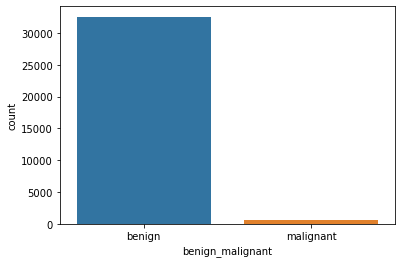

In [13]:
sns.countplot(train['benign_malignant'])

In [14]:
import matplotlib.cm as cm

In [15]:
fig = px.sunburst(data_frame=train,
                  path=['benign_malignant','sex','location','age'],
                  color='sex',
                  color_discrete_sequence=px.colors.qualitative.Antique,
                  maxdepth=-1,
                  title='Sunburst Chart Benign/Malignant > Sex > Location')

fig.update_traces(textinfo='label+percent parent')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

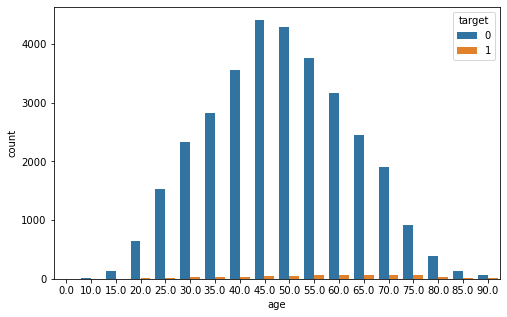

In [16]:
plt.figure(figsize=(8,5))
sns.countplot(train['age'], hue=train['target'])

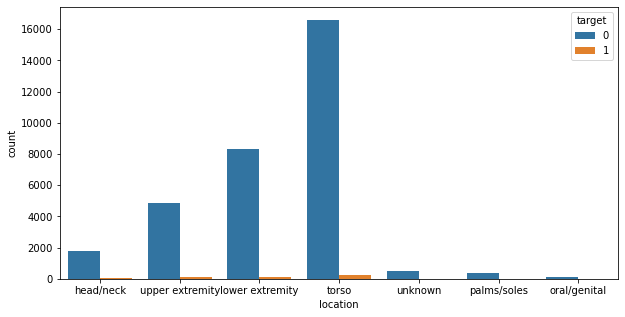

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(train['location'], hue=train['target'])

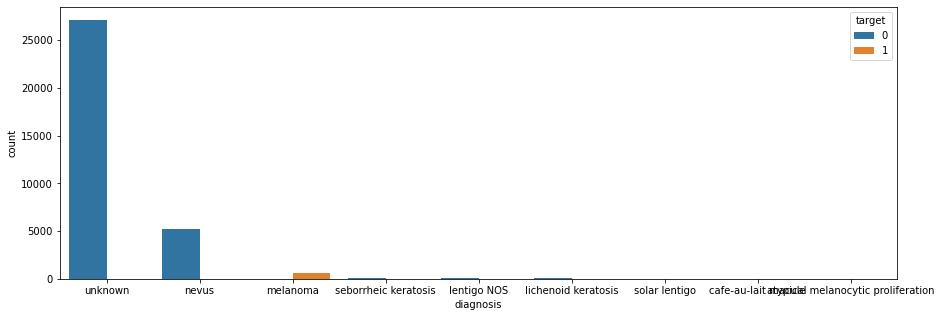

In [18]:
plt.figure(figsize=(15,5))
sns.countplot(train['diagnosis'], hue=train['target'])

# Correlations

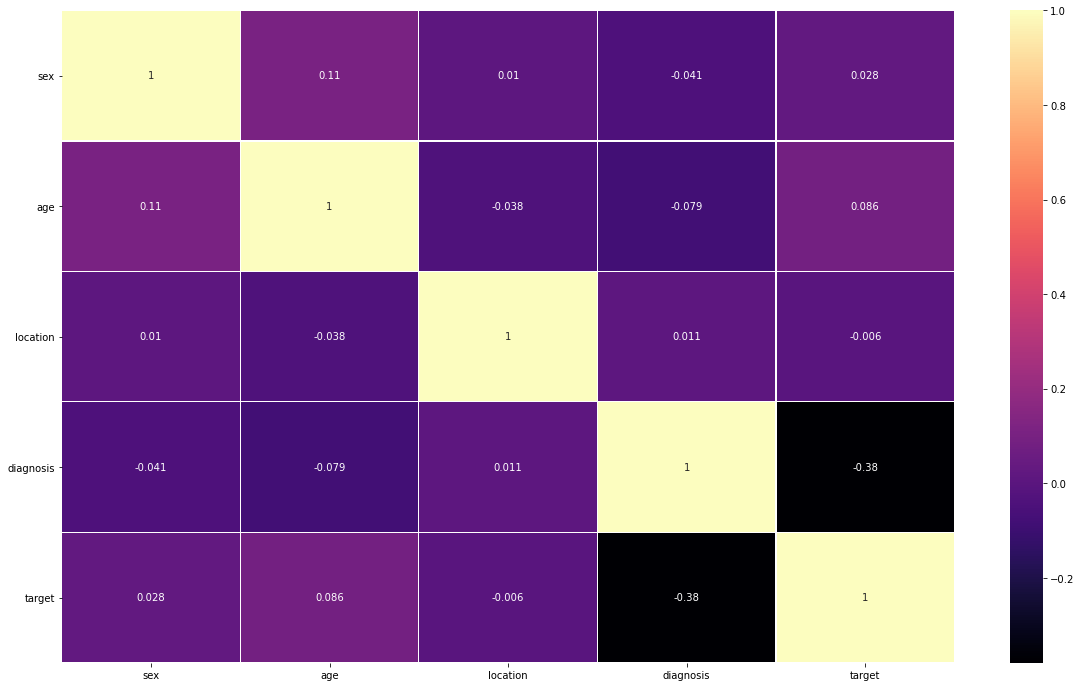

In [19]:
train_df = train[['sex','age','location','diagnosis','target']]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df = train_df.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')
sns.heatmap(train_df.corr(),annot=True,linewidths=0.2, cmap = 'magma') 
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

# Dealing with the Images 

In [20]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: 
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

cols, rows = 4, 3
def grid_display(list_of_images, no_of_columns=2, figsize=(15,15), title = None, titles = False):
    fig = plt.figure(figsize=figsize)
    column = 0
    z = 0
    for i in range(len(list_of_images)):
        column += 1
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        if title:
            plt.title(title)
        elif titles:
            if i >= no_of_columns:
                plt.title(titles[z])
                z +=1
            else:
                plt.title(titles[i])
        plt.imshow(list_of_images[i])
        plt.axis('off')

def visualize(image_list, title = None):
    image_all=[]
    for image_id in image_list:
        image_file = f'/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+image_id+'.jpg' 
        img = np.array(Image.open(image_file))
        image_all.append(img)
    return grid_display(image_all, 4, (15,15), title)   

# Visualizing the Images - Benign vs. Malignant

1. Benign

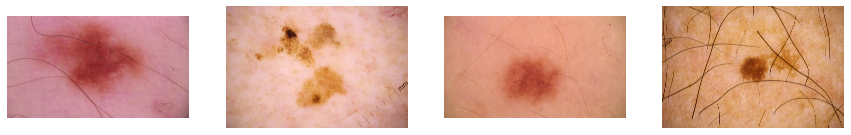

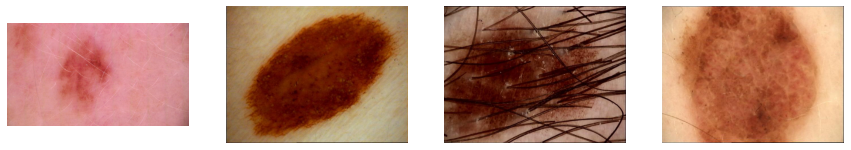

In [21]:
image_list = train[train['target'] == 0].sample(8)['img_name']
visualize(image_list)

2. Malignant

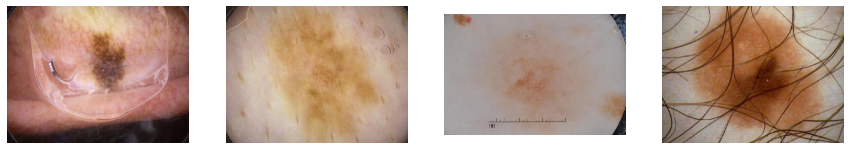

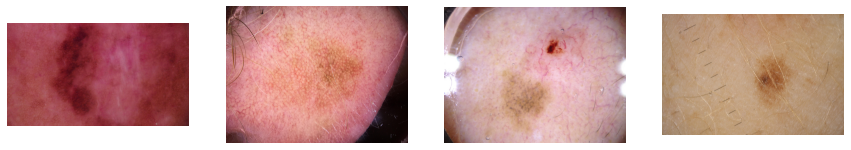

In [22]:
image_list = train[train['target'] == 1].sample(8)['img_name']
visualize(image_list)

# Visualizing the Images by Location

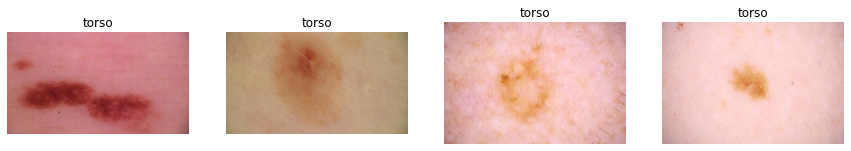

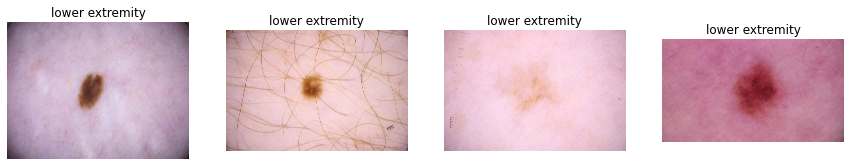

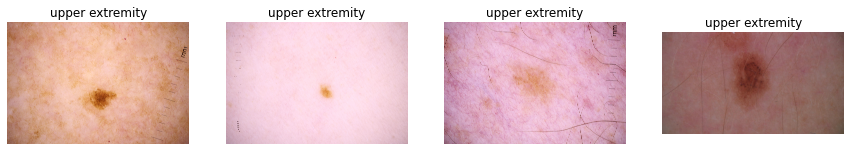

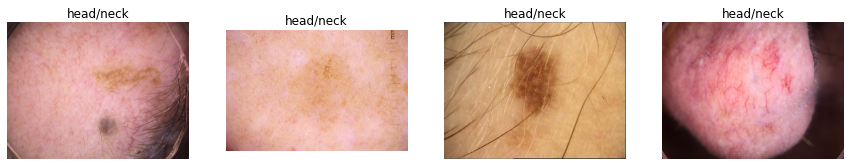

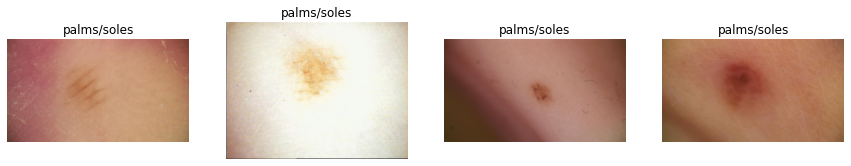

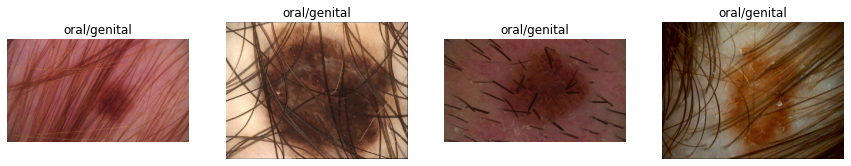

In [23]:
locations = ['torso','lower extremity','upper extremity','head/neck','palms/soles','oral/genital']
for loc in locations:
    image_list = train[train['location'] == loc].sample(4)['img_name']
    visualize(image_list, title = loc)

# Visualizing the Images by Diagnosis

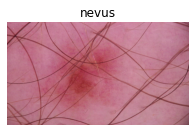

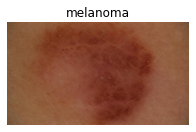

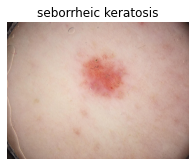

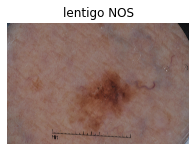

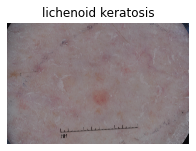

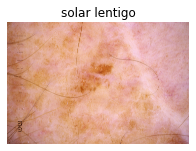

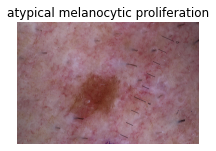

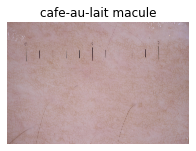

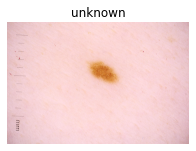

In [24]:
diagnoses = ['nevus','melanoma','seborrheic keratosis','lentigo NOS','lichenoid keratosis','solar lentigo','atypical melanocytic proliferation','cafe-au-lait macule','unknown']
for diagnosis in diagnoses:
    image_list = train[train['diagnosis'] == diagnosis].sample(1)['img_name']
    visualize(image_list, title = diagnosis)

# Visualizing the Images by Age

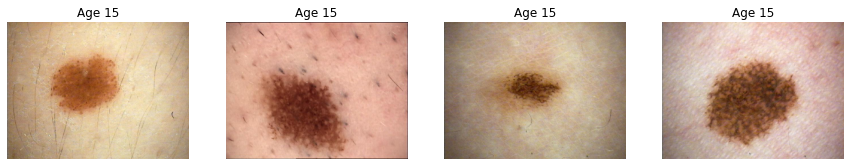

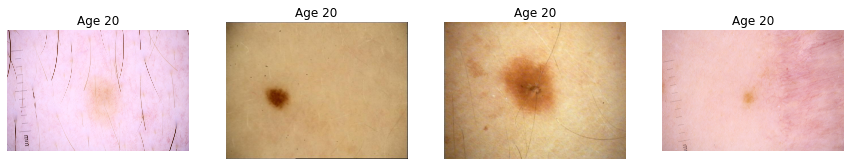

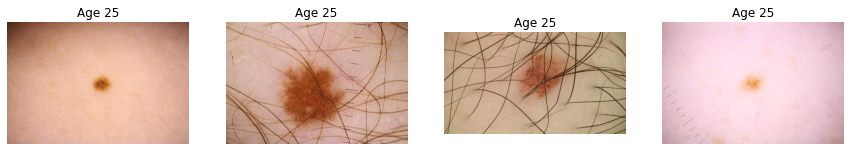

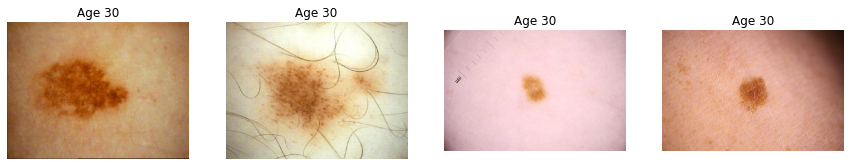

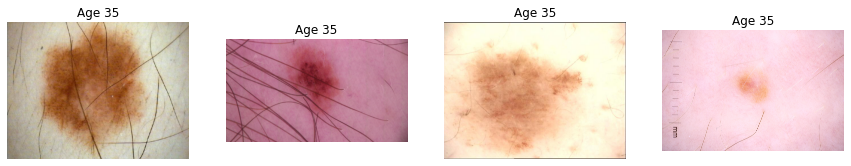

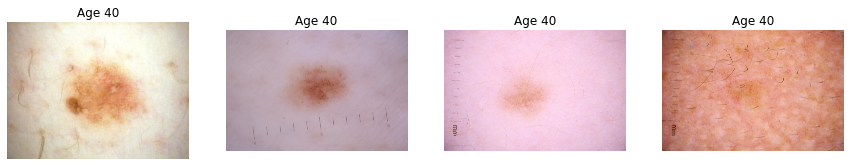

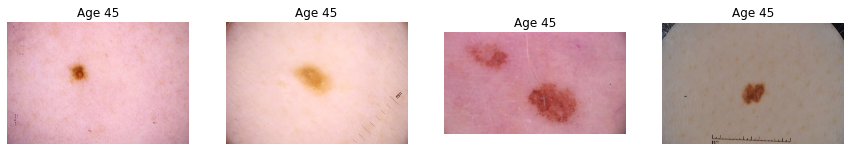

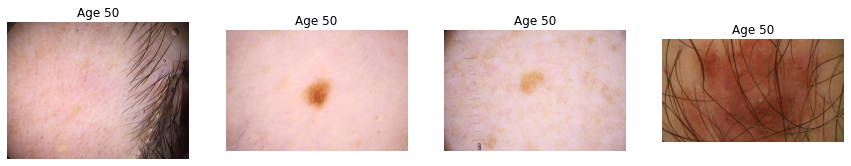

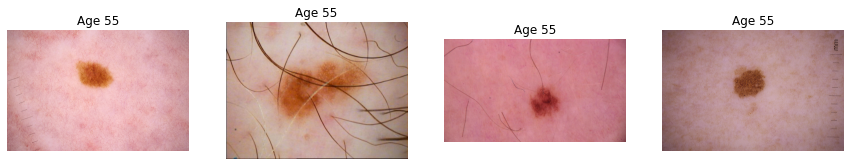

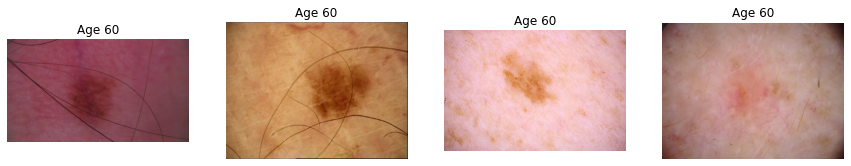

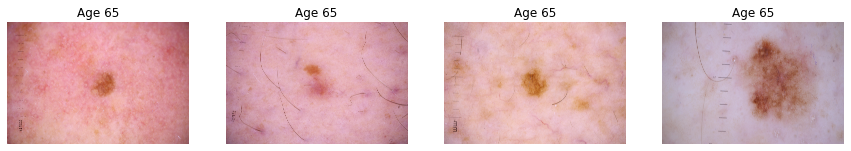

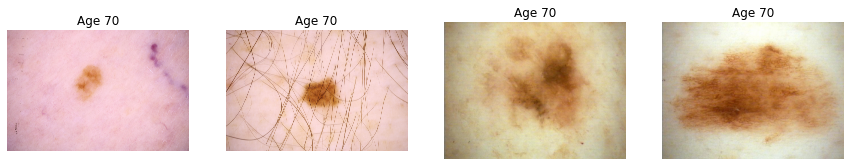

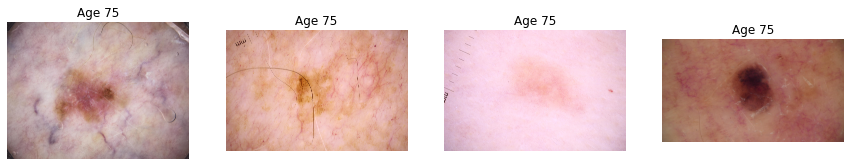

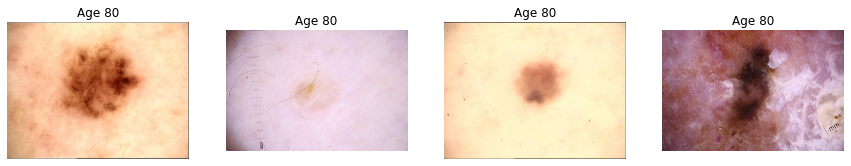

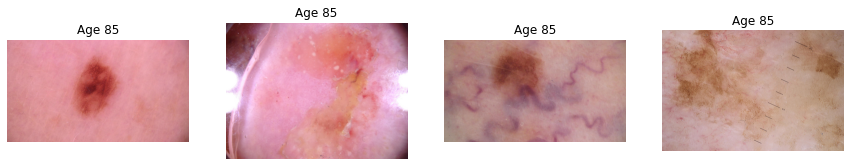

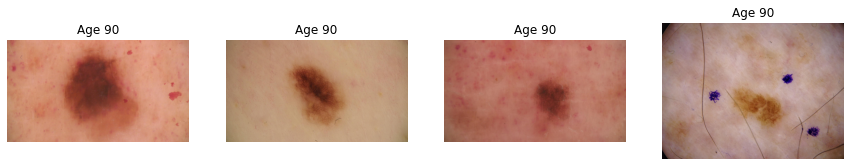

In [25]:
ages = [15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]
for age in ages:
    image_list = train[train['age'] == age].sample(4)['img_name']
    visualize(image_list, title = 'Age ' + str(age))

# Noise Reduction, Gaussian Blur and Contrast Adjustment
* In image processing, noise is a random variable with a mean of 0. A noisy pixel p could be written as p = p0 + n, where p0 is the true value of the pixel, and n is the noise. To remove this noise component, i.e. 'denoise' the pixel, the general procedure is to take a small window around each pixel, look for similar windows in the image, and average out all the noise components in these windows, making the overall noise negligible.This method is also called Non-Local Means Denoising.
* Gaussian Blur is a technique in which the image noise and detail are both reduced. A Gaussian function is used to calculate the transformation to apply to each pixel in the image. This results in a Gaussian distribution, from which values are taken to create a convolution matrix. The image is then convolved with this matrix.
* Contrast refers to the difference between the light and dark areas of the image. During adjustment, pixels above a certain value are mapped to white and pixels below a certain value are mapped to black.
* All the above techniques have been implemented using the OpenCV library.

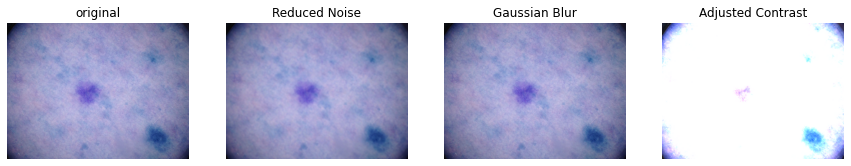

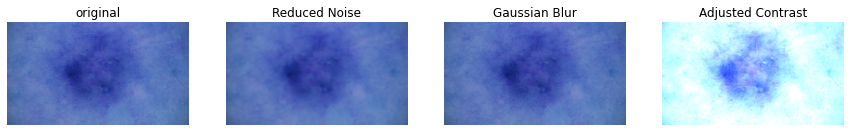

In [26]:
image_list = train[train['target'] == 1].sample(2)['img_name']
image_all=[]
titles = ['original', 'Reduced Noise', "Gaussian Blur", 'Adjusted Contrast']
for image_id in image_list:
    image_file = f'/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+image_id+'.jpg'
    img = cv2.imread(image_file,1)
    image_all.append(img)
   
    result = cv2.fastNlMeansDenoisingColored(img,None,20,10,7,21)
    image_all.append(result)
   
    blur_image = cv2.GaussianBlur(img, (7,7), 0)
    image_all.append(blur_image)
  
    contrast_img = cv2.addWeighted(img, 2.5, np.zeros(img.shape, img.dtype), 0, 0)
    image_all.append(contrast_img)
grid_display(image_all, 4, (15,15), titles = titles)

# Thresholding
* Image segmentation involves dividing an image into multiple parts or 'segments', primarily in order to identify parts of the image (lines, curves, etc.). Thresholding is a method of image segmentation, in which a conditional threshold value is used to assign standard values to pixels. 
* Binary thresholding involves only two standard values, assigned depending on whether the pixel value is above or below the threshold, which is constant for the entire image. 
* In adaptive thresholding, the image is divided into smaller regions, and the threshold value is specific to each region. Thus, there are multiple threshold and standard values.

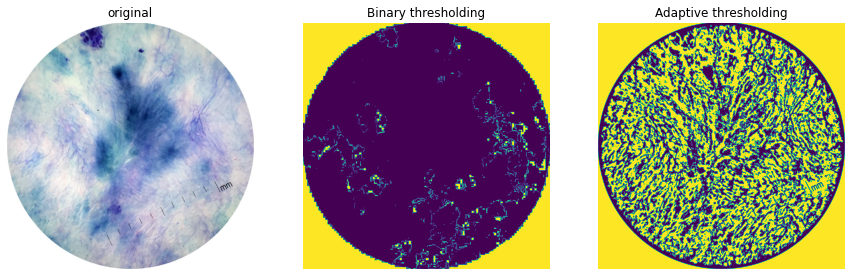

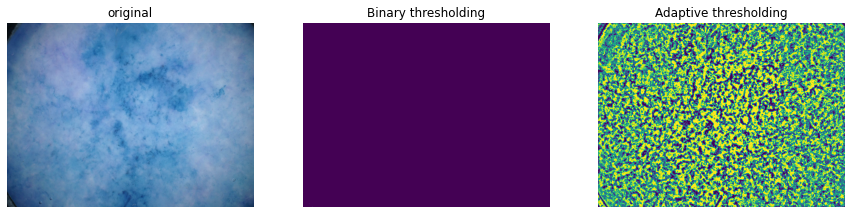

In [27]:
image_list = train[train['target'] == 1].sample(2)['img_name']
image_all=[]
titles = ['original','Binary thresholding','Adaptive thresholding']
for image_id in image_list:
    image_file = f'/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+image_id+'.jpg'
    img = cv2.imread(image_file,1)
    image_all.append(img)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
    res, thresh = cv2.threshold(hsv[:, :, 0], 0, 255, cv2.THRESH_BINARY_INV)
    image_all.append(thresh)
   
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh1 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    image_all.append(thresh1)
grid_display(image_all, 3, (15,15), titles = titles)

# Otsu's Thresholding
* An image histogram plots the number of pixels in the image for each tonal value (a value that determines the lightness of the image). 
* Otsu's thresholding is a form of binary thresholding in which the threshold value is calculated from the pixel distribution on the histogram.

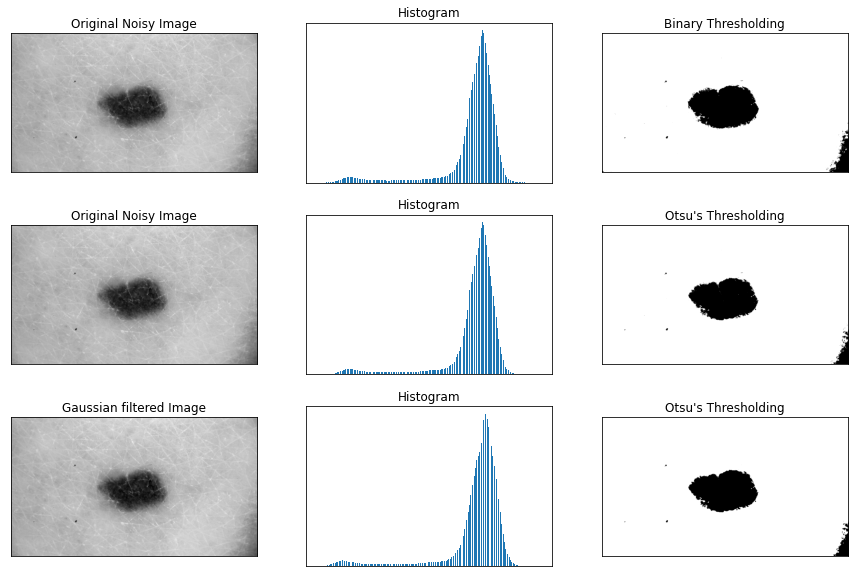

In [28]:
img = cv2.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_0052212.jpg', 0)

ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Binary Thresholding',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
plt.figure(figsize=(15,10))
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

# Contouring
A contour is a curve joining all the continuous points in an image with the same color or intensity. Contouring is very useful for object detection and recognition.

AREA:698301.0, perimeter:3396.0
AREA:5.5, perimeter:9.071067690849304
AREA:83.0, perimeter:43.79898953437805
AREA:54.5, perimeter:28.3847758769989
AREA:27.0, perimeter:22.14213526248932
AREA:8.5, perimeter:11.071067690849304
AREA:10.0, perimeter:11.656854152679443
AREA:15.0, perimeter:14.485281229019165
AREA:297.5, perimeter:97.1543276309967
AREA:51.5, perimeter:28.38477599620819
AREA:44.5, perimeter:27.55634880065918
AREA:13.0, perimeter:14.485281229019165
AREA:8.5, perimeter:11.071067690849304
AREA:4.0, perimeter:7.656854152679443
AREA:89.0, perimeter:40.627416253089905
AREA:115485.0, perimeter:1985.7484627962112
AREA:11.5, perimeter:14.242640614509583
AREA:0.0, perimeter:4.0
AREA:0.0, perimeter:0.0
AREA:0.0, perimeter:0.0
AREA:3.0, perimeter:7.656854152679443
AREA:60.5, perimeter:35.21320295333862
AREA:0.5, perimeter:3.414213538169861
AREA:87.0, perimeter:47.455843687057495
AREA:31.0, perimeter:23.313708424568176
AREA:0.0, perimeter:0.0
AREA:3.5, perimeter:8.242640614509583
AREA:3.0

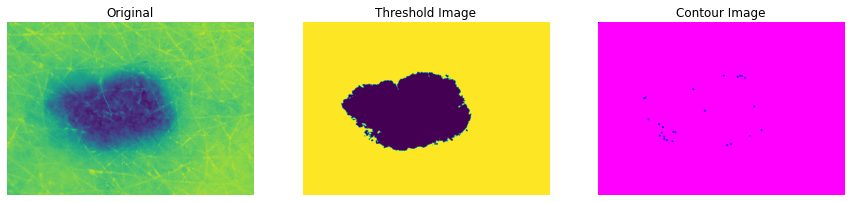

In [29]:
image = []
titles = ['Original', 'Threshold Image', 'Contour Image']
img = cv2.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_0052212.jpg', 0)
img = img[200:900, 500:1500]
image.append(img)

blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
image.append(th3)
contours, hierarchy = cv2.findContours(th3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img2 = img.copy()
index = -1
thickness = 4
color = (255, 0, 255)

objects = np.zeros([img.shape[0], img.shape[1], 3], 'uint8')
for c in contours:
    cv2.drawContours(objects, [c], -1, color, -1)
    
    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)
    
    M = cv2.moments(c)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0
    cv2.circle(objects, (cx, cy), 4, (0, 0, 255), -1)
    
    print("AREA:{}, perimeter:{}".format(area, perimeter))

image.append(objects)
grid_display(image, 3, (15,15), titles = titles)

# ORB (Oriented FAST and Rotated BRIEF)
* FAST (Features from Accelerated Segment Test) is an algorithm that helps in feature detection.
* BRIEF (Binary Robust Independent Elementary Features) is an algorithm that gives the decriptors and orientation of the image.
* ORB uses FAST to locate the keypoints, BRIEF for their orientations, and uses these to compute a rotation matrix for the image. It then gives the rotated image as the output.

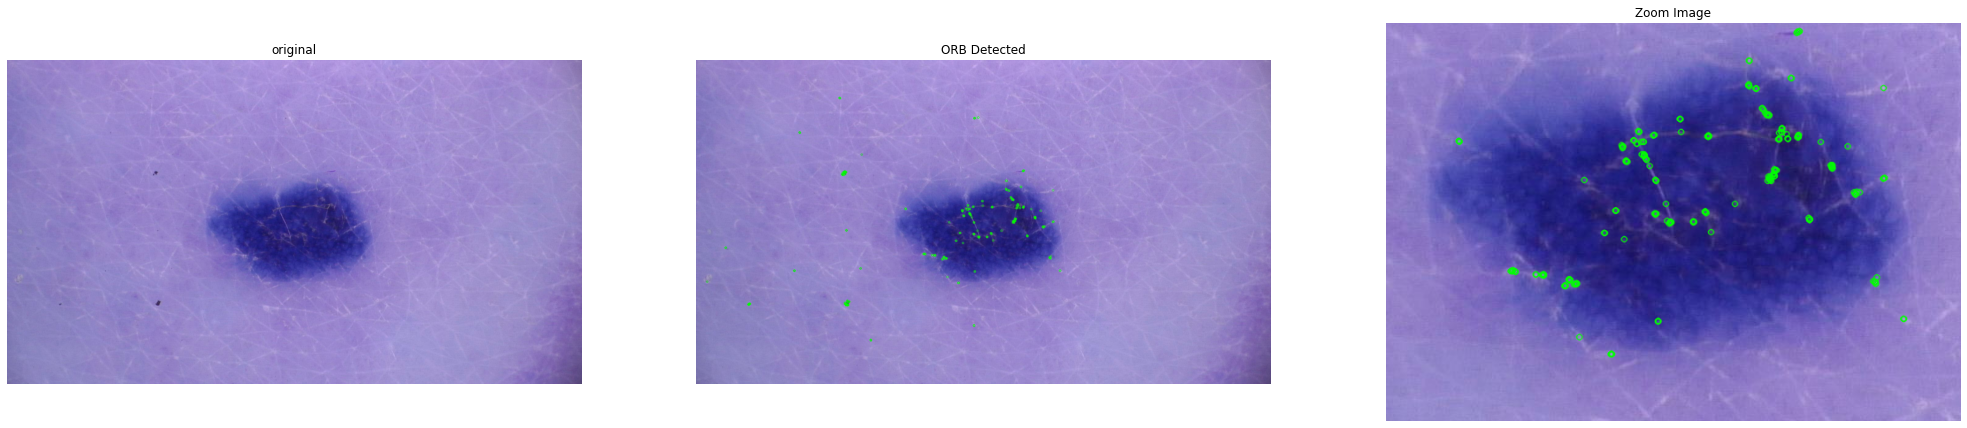

In [30]:
image_all=[]
titles = ['original', 'ORB Detected', "Zoom Image"]
img = cv2.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_0052212.jpg', 1)
image_all.append(img)

orb = cv2.ORB_create()

kp = orb.detect(img,None)

kp, des = orb.compute(img, kp)

img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
image_all.append(img2)
img3 = img2[350:800,600:1250]
image_all.append(img3)
grid_display(image_all, 3, (35,35), titles = titles)

# XGBOOST PREDICTIONS
This is a basic test of a machine learning model on only the metadata

In [31]:
train

img_name          id     sex   age         location diagnosis  \
0      ISIC_2637011  IP_7279968    male  45.0        head/neck   unknown   
1      ISIC_0015719  IP_3075186  female  45.0  upper extremity   unknown   
2      ISIC_0052212  IP_2842074  female  50.0  lower extremity     nevus   
3      ISIC_0068279  IP_6890425  female  45.0        head/neck   unknown   
4      ISIC_0074268  IP_8723313  female  55.0  upper extremity   unknown   
...             ...         ...     ...   ...              ...       ...   
33121  ISIC_9999134  IP_6526534    male  50.0            torso   unknown   
33122  ISIC_9999320  IP_3650745    male  65.0            torso   unknown   
33123  ISIC_9999515  IP_2026598    male  20.0  lower extremity   unknown   
33124  ISIC_9999666  IP_7702038    male  50.0  lower extremity   unknown   
33125  ISIC_9999806  IP_0046310    male  45.0            torso     nevus   

      benign_malignant  target  
0               benign       0  
1               benign       0  
2               benign       0  
3               benign       0  
4               benign       0  
...                ...     ...  
33121           benign       0  
33122           benign       0  
33123           benign       0  
33124           benign       0  
33125           benign       0  

[33126 rows x 8 columns]

In [32]:
cols_ignore = ['img_name','id','benign_malignant','diagnosis']
cols_y = ['target']
cols_X = list(set(train.columns) - set(cols_y) - set(cols_ignore))

In [33]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X = train[cols_X].apply(le.fit_transform)
y = train[cols_y]

**Train_Test_Split**

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

**Model**

In [35]:
import xgboost as xgb
clf = xgb.XGBClassifier(n_estimators=3000, 
                        max_depth=18, 
                        learning_rate=0.15,  
                        objective='binary:logistic',
                        seed=0,  
                        nthread=-1).fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



**Predictions**

In [36]:
xgb_preds = clf.predict(X_test)
xgb_preds

array([0, 0, 0, ..., 0, 0, 0])

**Evaluation**

In [37]:
roc_auc_score(y_test,xgb_preds)

0.506578947368421

# TPU Detection
A tensor processing unit (TPU) is an AI accelerator application-specific integrated circuit (ASIC) developed by Google specifically for neural network machine learning. This allows for much larger sizes of data. The TPU used here is Kaggle's virtual version.

In [38]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None

  gpus = tf.config.experimental.list_logical_devices("GPU")
    

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) 
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')


print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
Number of accelerators:  8


In [39]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')

# Neural Network for Predictions - Xception Network
* The Inception network or GoogleNet was built to combat the limitations of other deep neural networks, like overfitting and and limited computational resources, using an inception layer that allows the filter layer dimensions to be chosen specifically for each layer, thus allowing the NN to go deeper.
* The Xception is a convolutional neural network that was built on the same principle as the Inception network, but replaces Inception layers with depthwise seperable layers, outperforming the Inception network especially on extremely large data resources.

# Train-Validation-Test Split
For the purpose of the IBM Final Project, the train files will be split into train, validation and test sets in lieu of making the predictions on the test data from the hackathon

In [40]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords/train*')
#TEST_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords/test*')
BATCH_SIZE = 10 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]
AUTO = tf.data.experimental.AUTOTUNE
imSize = 1024
EPOCHS = 10

TEST_SPLIT = 0.10
split = int(len(TRAINING_FILENAMES) * TEST_SPLIT)
training_filenames = TRAINING_FILENAMES[split:]
test_filenames = TRAINING_FILENAMES[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files"
      .format(len(TRAINING_FILENAMES), len(training_filenames), len(test_filenames)))
TRAINING_FILENAMES = training_filenames

VALIDATION_SPLIT = 0.15
split = int(len(TRAINING_FILENAMES) * VALIDATION_SPLIT)
training_filenames = TRAINING_FILENAMES[split:]
validation_filenames = TRAINING_FILENAMES[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files"
      .format(len(TRAINING_FILENAMES), len(training_filenames), len(validation_filenames)))
TRAINING_FILENAMES = training_filenames

Pattern matches 16 data files. Splitting dataset into 15 training files and 1 validation files
Pattern matches 15 data files. Splitting dataset into 13 training files and 2 validation files


# Functions for the Model
* read_labeled_tfrecord - reads labeled data
* read_unlabeled_tfrecord - reads unlabeled data
* load_dataset - dataset of both labeled and unlabeled data
* data_augment - augmented images
* get_(training,test)_datasets - the datasets for the model and predictions
* count_data_items - number of items in each dataset

In [41]:
def read_labeled_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "target": tf.io.FixedLenFeature([], tf.int64),  
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) 
    image = tf.image.resize(image, [imSize,imSize])
    label = tf.cast(example['target'], tf.int32)
    return image, label 

def read_unlabeled_tfrecord(example):
    u_features = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string),  
    }
    example = tf.io.parse_single_example(example, u_features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) 
    image = tf.image.resize(image, [imSize,imSize])
    idnum = example['image_name']
    return image, idnum 

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)  
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

In [42]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label   

def get_training_dataset(dataset, do_aug=True):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() 
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_test_dataset(filenames, train=False):
    dataset = load_dataset(filenames, labeled=True)
    dataset = dataset.cache() 
    if train:
        dataset = dataset.repeat()
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        dataset = dataset.shuffle(2000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

validation_dataset = get_test_dataset(validation_filenames, train=False)
training_dataset = get_training_dataset(TRAINING_FILENAMES)
test_dataset = get_test_dataset(test_filenames, train = False)
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(test_filenames)
NUM_VALID_IMAGES = count_data_items(validation_filenames)
validation_steps = NUM_VALID_IMAGES // BATCH_SIZE
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} unlabeled test images, {} validition images'
      .format(NUM_TRAINING_IMAGES, NUM_TEST_IMAGES, NUM_VALID_IMAGES))

Dataset: 26913 training images, 2071 unlabeled test images, 4142 validition images


In [43]:
print("Training data shapes:")
for image, label in training_dataset.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

print("Validation data shapes:")
for image, label in validation_dataset.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())

print("Test data shapes:")
for image, idnum in test_dataset.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U'))

Training data shapes:
(80, 1024, 1024, 3) (80,)
(80, 1024, 1024, 3) (80,)
(80, 1024, 1024, 3) (80,)
Training data label examples: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Validation data shapes:
(80, 1024, 1024, 3) (80,)
(80, 1024, 1024, 3) (80,)
(80, 1024, 1024, 3) (80,)
Validation data label examples: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Test data shapes:
(80, 1024, 1024, 3) (80,)
(80, 1024, 1024, 3) (80,)
(80, 1024, 1024, 3) (80,)
Test data IDs: ['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '0' '0' '0' '0'
 '0' 

# The Xception Net Model

In [44]:
import tensorflow.keras.applications.xception as xcep
with strategy.scope():
    model = tf.keras.Sequential([
        xcep.Xception(
            input_shape=(imSize, imSize, 3),
            weights='imagenet',
            include_top=False
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation= 'relu'), 
        layers.Dropout(0.2),
        layers.Dense(512, activation= 'relu'), 
        layers.Dropout(0.2), 
        layers.Dense(256, activation='relu'), 
        layers.Dropout(0.2), 
        layers.Dense(128, activation='relu'), 
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu'), 
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ])
        
    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

83689472/83683744 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 32, 32, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________

In [45]:
def lrfn(epoch):
    LR_START = 0.00001
    LR_MAX = 0.00005 * strategy.num_replicas_in_sync
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8
    
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [46]:
EPOCHS = 10
history = model.fit(training_dataset, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=validation_dataset,callbacks=[lr_schedule])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
336/336 [==============================] - 402s 1s/step - accuracy: 0.9574 - loss: 0.2021 - val_accuracy: 0.9836 - val_loss: 0.0819 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/10
336/336 [==============================] - 368s 1s/step - accuracy: 0.9821 - loss: 0.0808 - val_accuracy: 0.9836 - val_loss: 0.0833 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/10
336/336 [==============================] - 367s 1s/step - accuracy: 0.9818 - loss: 0.0768 - val_accuracy: 0.9836 - val_loss: 0.1121 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/10
336/336 [==============================] - 367s 1s/step - accuracy: 0.9826 - loss: 0.0711 - val_accuracy: 0.9836 - val_loss: 0.0657 - lr: 2.4400e-04

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoc

# Model Performance

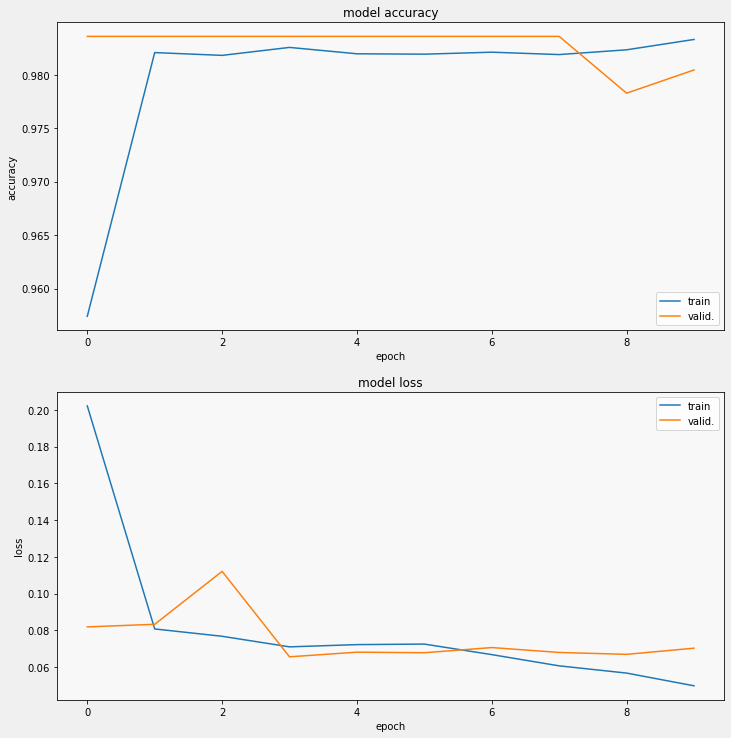

In [47]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [48]:
test_dataset

<PrefetchDataset shapes: ((None, 1024, 1024, 3), (None,)), types: (tf.float32, tf.int32)>

In [49]:
y_true = []
for image, label in test_dataset:
    for l in label:
        y_true.append(l.numpy())
print(y_true)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Xception Predictions and Performance

In [50]:
probabilities = model.predict(test_dataset)
y_preds = np.where(probabilities>0.5,1,0)
print(y_preds)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [51]:
roc_auc_score(y_preds,y_true)

0.6290820829655781

# Conclusion
After intensive data exploration, cleaning and preprocessing and feature engineering, the predictions were made on on ML algorithm (XGBoost Classifier) and one DL algorithm (Xception Network). The use case can be solved with the latter, as it gives the encoded diagnosis (benign/malignant) as the output. The roc-auc score can be further improved with even more feature engineering and image augmentation.